In [0]:
%matplotlib  inline
%reload_ext autoreload
%autoreload 2


# **Telenav.AI**



This Dataset is from  [Telenav AI](https://github.com/Telenav/Telenav.AI) .It contains over 45 000 manually annotated images containing more than 55 000 signs divided in 23 different classes such as : traffic signals, stop signs, speed limits and turn restrictions. 

The objective  of this Project is to identify the largest object Detected in an Image given the metadata .


This Notebook is adapted from the fast.ai Course  Notebook on Object Detection on Pascal Dataset.

In [0]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import cv2
import numpy as np
from glob import glob

from fastai.conv_learner import *
from fastai.dataset import *


from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [135]:
from pathlib import Path
PATH = Path('./telenav_ai_dataset_sample/')
list(PATH.iterdir())

[PosixPath('telenav_ai_dataset_sample/.ipynb_checkpoints'),
 PosixPath('telenav_ai_dataset_sample/protobuf'),
 PosixPath('telenav_ai_dataset_sample/sample_data'),
 PosixPath('telenav_ai_dataset_sample/LICENSE'),
 PosixPath('telenav_ai_dataset_sample/README.md')]

In [136]:
JPEGS = './sample_data/'
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('telenav_ai_dataset_sample/sample_data/332187_81610_5923875a15f50.jpg'),
 PosixPath('telenav_ai_dataset_sample/sample_data/471839_ac6fc_28.jpg'),
 PosixPath('telenav_ai_dataset_sample/sample_data/366151_35eee_5926154f8e7e4.jpg'),
 PosixPath('telenav_ai_dataset_sample/sample_data/526369_b8e0e_13.jpg'),
 PosixPath('telenav_ai_dataset_sample/sample_data/16168_a9b9c_57c920d74c2c7.jpg')]

There are 23 different  Traffic Signs ,NA is used for the images where no objects are detected.

In [0]:

CLASS_NAME_DICT  =  dict(
              ((10,  'NA'),
               (40,  'TURN_RESTRICTION_US_RIGHT'),
               (41,  'TURN_RESTRICTION_US_UTURN'),
               (43,  'SL_STOP_SIGN'),
               (123, 'TRAFFIC_LIGHTS_SIGN'),
               (39,  'TURN_RESTRICTION_US_LEFT'),
               (16,  'SL_US_5'), 
               (17,  'SL_US_10'), 
               (18,  'SL_US_15'), 
               (19,  'SL_US_20'), 
               (20,  'SL_US_25'),
               (21,  'SL_US_30'), 
               (22,  'SL_US_35'), 
               (23,  'SL_US_40'), 
               (24,  'SL_US_45'), 
               (25,  'SL_US_50'),
               (26,  'SL_US_55'), 
               (27,  'SL_US_60'), 
               (28,  'SL_US_65'), 
               (29,  'SL_US_70'), 
               (30,  'SL_US_75'),
               (31,  'SL_US_80'),
               (42,  'TURN_RESTRICTION_US_LEFT_UTURN'),
               (69,  'GIVE_WAY')))



The Dataset contains  a Helper Code to read the metadata.

In [0]:
sys.path.append("./telenav_ai_dataset_sample/protobuf")
import proto_api as proto_api

images_folder = "./telenav_ai_dataset_sample/sample_data/"
rois_path = os.path.join(images_folder,"rois.bin")
images_paths = glob(images_folder + "*[jpg,jpeg]")

imageset_proto = proto_api.read_metadata(rois_path)


In [0]:
def read_df(metadata):

    images = metadata.images    
    data_df = pd.DataFrame({"img_proto": images})
    data_df.loc[:,"img_name"] = data_df.loc[:,"img_proto"].apply(lambda image: image.metadata.image_path)
    data_df.loc[:, "rois"] = data_df.loc[:,"img_proto"].apply(lambda image:image.rois)
    data_df.loc[:, "number_of_objects"] = data_df.loc[:,"rois"].apply(len)
    data_df = data_df.drop(["img_proto"],axis=1)
        
    return data_df

In [132]:
data_df = read_df(imageset_proto)
data_df.head()

,img_name,rois,number_of_objects
0,10676_19a5b_579a6ef320f18.jpg,[type: TRAFFIC_LIGHTS_SIGN\nrect {\n tl {\n ...,5
1,50486_1d629_58b79c6830a01.jpg,[],0
2,493719_5129c_6.jpg,[type: SPEED_LIMIT_30_US\nrect {\n tl {\n ...,1
3,527601_d3dc2_25.jpg,[type: SPEED_LIMIT_65_US\nrect {\n tl {\n ...,1
4,427178_3deb8_592f99e0564f2.jpg,[type: TRAFFIC_LIGHTS_SIGN\nrect {\n tl {\n ...,10


In [146]:
data_df.iloc[0].rois

[type: TRAFFIC_LIGHTS_SIGN
rect {
  tl {
    row: 934
    col: 1572
  }
  br {
    row: 1029
    col: 1636
  }
}
manual: true
algorithm: ""
validation: TRUE_POSITIVE
, type: TRAFFIC_LIGHTS_SIGN
rect {
  tl {
    row: 930
    col: 1004
  }
  br {
    row: 1025
    col: 1064
  }
}
manual: true
algorithm: ""
validation: TRUE_POSITIVE
, type: TURN_RESTRICTION_RIGHT_US
rect {
  tl {
    row: 342
    col: 2190
  }
  br {
    row: 471
    col: 2340
  }
}
manual: true
algorithm: ""
validation: TRUE_POSITIVE
, type: TURN_RESTRICTION_RIGHT_US
rect {
  tl {
    row: 989
    col: 468
  }
  br {
    row: 1019
    col: 492
  }
}
manual: true
algorithm: ""
validation: TRUE_POSITIVE
, type: TURN_RESTRICTION_RIGHT_US
rect {
  tl {
    row: 1017
    col: 1772
  }
  br {
    row: 1050
    col: 1809
  }
}
manual: true
algorithm: ""
validation: TRUE_POSITIVE
]

# **Large Size Images !**

The sizes of the Images are quite large compared to ImageNet .need to take care during Training with pre-trained models which are trained with (224 * 224)

In [144]:
images = [f'{IMG_PATH}/{k}' for k in data_df['img_name']]
{PIL.Image.open(img).size for img in images}

{(1080, 1920),
 (1920, 1080),
 (1936, 2592),
 (2160, 2160),
 (2560, 1920),
 (2576, 1932),
 (2592, 1936),
 (2592, 1944),
 (3024, 4032),
 (3264, 2448),
 (3488, 3488),
 (3808, 2144),
 (3840, 2160),
 (4000, 3000),
 (4032, 3024),
 (4608, 2592),
 (5312, 2988)}

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [0]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [0]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle((b[0] ,b[1]), b[2]-b[0],b[3]-b[1], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [0]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)


Make a Dictionary  of  {  ImageName.jpg : Bounding Box Co-ordinates of each Object Marked in the Image , Traffic Signs }

In [130]:
import collections

trn_anno = collections.defaultdict(lambda:[])
for _,row in tmp_df.iterrows():
  
        bbox = []
        gt_image_rois = row["rois"]
        img_name = row["img_name"]
        roi_type=10
        
        
        for roi in gt_image_rois:
            tl_col = roi.rect.tl.col
            tl_row = roi.rect.tl.row
            br_col = roi.rect.br.col
            br_row = roi.rect.br.row
            bbox = np.array([tl_col, tl_row, br_col, br_row])
            roi_type = roi.type           

            trn_anno[img_name].append((bbox,roi_type))
            
            
        if (len(bbox) == 0) :
            trn_anno[img_name].append((bbox,roi_type))


        
len(trn_anno)

1000

In [0]:
def get_lrg(b):
    if not b or len(b[0][0]) == 0: return []
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

# **Largest Object **

Get the Largest Object marked in the Image by taking the co-ordinates of the Bounding Box.
So we now have 2 Dictionaries :

1. trn_anno          :      { ImageName.jpg : Bounding Box Co-ordinates of each Object Marked in the Image , Traffic Signs }
2. trn_lrg_anno    :      { ImageName.jpg : Bounding Box Co-ordinates of **Largest** Object Marked in the Image , Traffic Signs }

In [0]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}


Lets check some images and see if the Largest Object is picked .

In [0]:
check_img = '10676_19a5b_579a6ef320f18.jpg'

In [138]:
im_anno = trn_anno[check_img]; im_anno

[(array([1572,  934, 1636, 1029]), 123),
 (array([1004,  930, 1064, 1025]), 123),
 (array([2190,  342, 2340,  471]), 40),
 (array([ 468,  989,  492, 1019]), 40),
 (array([1772, 1017, 1809, 1050]), 40)]

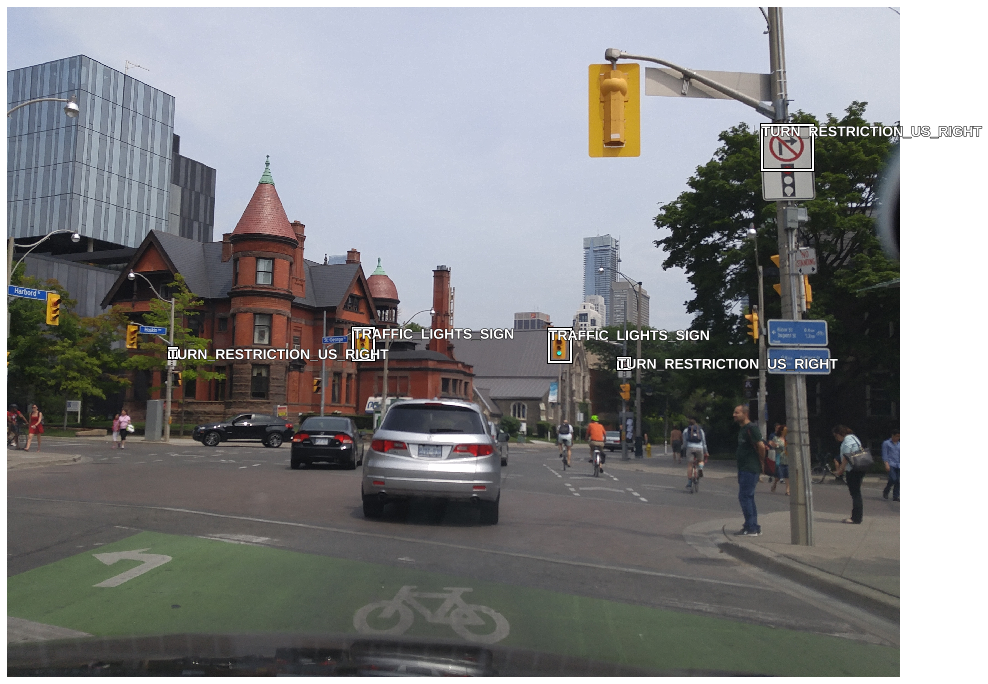

In [139]:
im = open_image(IMG_PATH/check_img)
ax = show_img(im,figsize=(16,14))

for i in range(len(im_anno)):
    b = im_anno[i][0]
    #print(b)
    #print(CLASS_NAME_DICT[im_anno[i][1]])
    draw_rect(ax, b)
    draw_text(ax, b[:2], CLASS_NAME_DICT[im_anno[i][1]])

In [140]:
im_anno = trn_lrg_anno[check_img]; im_anno

(array([2190,  342, 2340,  471]), 40)

[2190  342 2340  471]
TURN_RESTRICTION_US_RIGHT


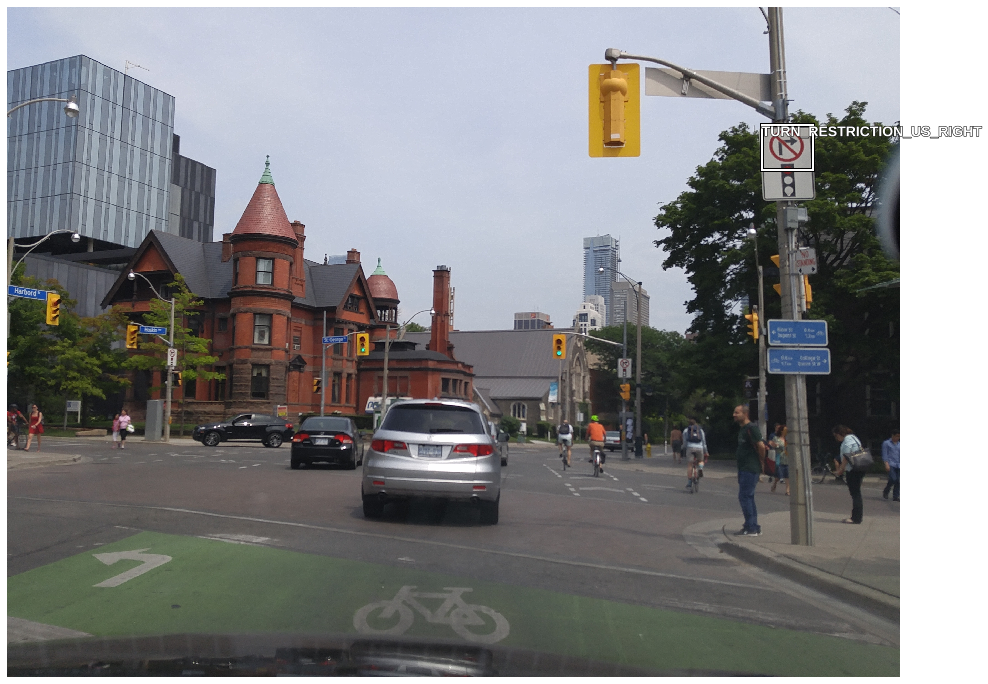

In [145]:
im = open_image(IMG_PATH/check_img)
ax = show_img(im,figsize=(16,14))

for i in range(len(im_anno)-1):
    b = im_anno[i]
    print(b)
    print(CLASS_NAME_DICT[im_anno[1]])
    draw_rect(ax, b)
    draw_text(ax, b[:2], CLASS_NAME_DICT[im_anno[1]])